## Super Resolution GAN validation procedures

In [14]:
import torch
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
import os
import numpy as np
from torchvision.utils import save_image
from tqdm import tqdm
import matplotlib.pyplot as plt
from SRGAN.model import *
import gc

MODEL_PATH = "SRGAN"
LR_PATH = "DIV2K_valid_LR_bicubic/X4"
HR_PATH = "DIV2K_valid_HR"

CHECKPOINT_GEN = "gen_srgan.pth"
#LR_PATH = "test_images"
RESULT_IMAGES = "result_images"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [15]:
# Download low-res validation dataset
#!wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_LR_bicubic_X4.zip
#!unzip DIV2K_valid_LR_bicubic_X4.zip

In [16]:
# Download high-res validation dataset
#!wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip
#!unzip DIV2K_valid_HR.zip 

In [17]:
# Test image transformation
test_transform = A.Compose(
    [
        A.Normalize(mean=[0, 0, 0], std=[1, 1, 1]),
        ToTensorV2(),
    ]
)

In [18]:
# PSNR loss function
def psnr_loss(upscaled_img, valid_img):
        psnr = 10. * torch.log10(1. / torch.mean((upscaled_img - valid_img) ** 2))
        return psnr.item()

In [19]:
# Load pre-trained model state
def load_model(filename, model):
    filename = os.path.join(MODEL_PATH, filename)
    print("=> Loading model from " + filename)
    checkpoint = torch.load(filename, map_location=DEVICE)
    model.load_state_dict(checkpoint["state_dict"])

In [20]:
# Reading low-res images and convert them into high-res images 
def plot_examples(gen):
    # For all files in low-res folder
    files = os.listdir(LR_PATH)
    total_psnr = []
    total_files = []
    gen.eval()
    loop = tqdm(files, leave=True)
    for file in loop:
        psnr = 0.
        image = Image.open(os.path.join(LR_PATH, file))
        
        with torch.no_grad():
            upscaled_img = gen(test_transform(image=np.asarray(image))["image"].unsqueeze(0).to(DEVICE))
            upscaled_img = upscaled_img.detach().to('cpu') * 0.5 + 0.5
        # Save reconstructed image to disk
        fname, fext = os.path.splitext(file)
        fname = fname.replace('x4', 'u4')
        save_image(upscaled_img, os.path.join(RESULT_IMAGES, fname + fext))

        # Trying to find validation hi-res image for an upscaled low-res image
        fname = fname.replace('u4', '')
        valid_file = os.path.join(HR_PATH, fname + fext)
        # Calculating PSNR for validation and reconstructed images
        if os.path.exists(valid_file):
            image = Image.open(valid_file)
            valid_img = test_transform(image=np.asarray(image))["image"]
            psnr = psnr_loss(upscaled_img.squeeze(0), valid_img)
        loop.set_postfix(file=file, psnr=psnr)
        total_psnr.append(psnr)
        total_files.append(file)
    return total_files, total_psnr

=> Loading model from SRGAN\gen_srgan.pth


100%|██████████| 100/100 [02:50<00:00,  1.71s/it, file=0900x4.png, psnr=25.4]


PSNR per files
File name = 0801x4.png, PSNR = 27.42
File name = 0802x4.png, PSNR = 32.69
File name = 0803x4.png, PSNR = 35.43
File name = 0804x4.png, PSNR = 25.87
File name = 0805x4.png, PSNR = 27.44
File name = 0806x4.png, PSNR = 26.74
File name = 0807x4.png, PSNR = 19.45
File name = 0808x4.png, PSNR = 25.62
File name = 0809x4.png, PSNR = 30.38
File name = 0810x4.png, PSNR = 25.63
File name = 0811x4.png, PSNR = 27.75
File name = 0812x4.png, PSNR = 26.22
File name = 0813x4.png, PSNR = 29.52
File name = 0814x4.png, PSNR = 26.84
File name = 0815x4.png, PSNR = 31.69
File name = 0816x4.png, PSNR = 30.16
File name = 0817x4.png, PSNR = 29.86
File name = 0818x4.png, PSNR = 27.05
File name = 0819x4.png, PSNR = 26.59
File name = 0820x4.png, PSNR = 22.84
File name = 0821x4.png, PSNR = 28.21
File name = 0822x4.png, PSNR = 28.75
File name = 0823x4.png, PSNR = 24.73
File name = 0824x4.png, PSNR = 26.48
File name = 0825x4.png, PSNR = 25.69
File name = 0826x4.png, PSNR = 23.23
File name = 0827x4.png,

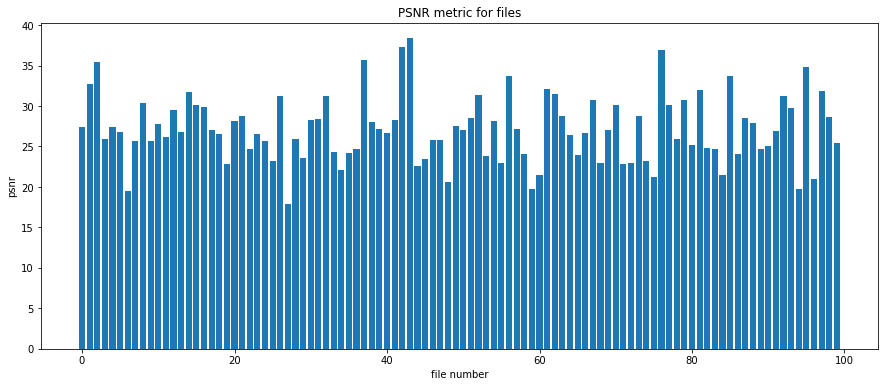

In [21]:
def main():
    
    # Loading the pre-trained image generator
    gen = Generator(in_channels=3).to(DEVICE)
    load_model(CHECKPOINT_GEN, gen)

    total_files, total_psnr = plot_examples(gen)
    print('PSNR per files')
    # Processing low-res images
    for i in range(len(total_files)):
        print(f'File name = {total_files[i]}, PSNR = {total_psnr[i]:.2f}')
    
    mean_psnr = np.array(total_psnr).mean()
    print(f'Mean PSNR for all files = {mean_psnr:.4f}')
    # Show PSNR
    plt.figure(figsize=(15, 6))
    plt.bar(range(len(np.array(total_psnr))), np.array(total_psnr))
    plt.xlabel('file number')
    plt.ylabel('psnr')
    plt.title('PSNR metric for files')
    plt.show()
    
    del(gen)

main()

In [22]:
gc.collect()
torch.cuda.empty_cache()

In [23]:
###############################